## Importing Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

### Read CSV and preprocessing columns

In [2]:
data = pd.read_csv("2010_2023_preprocessed_data.csv", index_col=0)

In [3]:
data.head()

,Date,Close
0,2010-04-07,8.592857
1,2010-04-08,8.569643
2,2010-04-09,8.635357
3,2010-04-12,8.653214
4,2010-04-13,8.658214


In [4]:
data["Date"] = pd.to_datetime(data["Date"])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3274 entries, 0 to 3273
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3274 non-null   datetime64[ns]
 1   Close   3274 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 205.8 KB


In [6]:
data.head()

,Date,Close
0,2010-04-07,8.592857
1,2010-04-08,8.569643
2,2010-04-09,8.635357
3,2010-04-12,8.653214
4,2010-04-13,8.658214


Text(0, 0.5, 'Price')

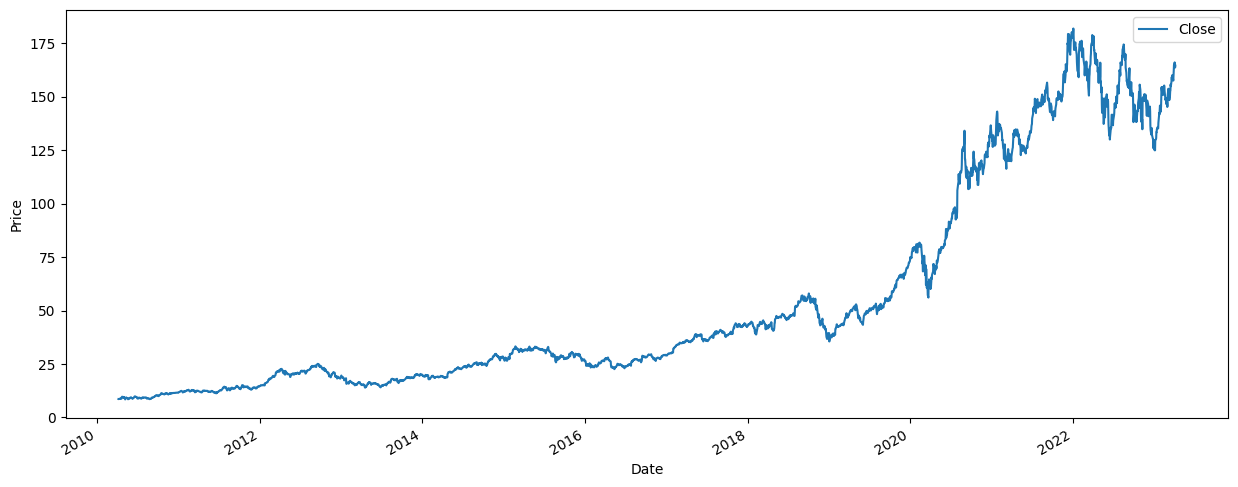

In [7]:
data.plot(x='Date', y='Close', figsize=(15,6))
plt.xlabel("Date")
plt.ylabel("Price")

In [8]:
data.set_index('Date', drop=True, inplace=True)

In [9]:
data.head()

,Close
Date,
2010-04-07,8.592857
2010-04-08,8.569643
2010-04-09,8.635357
2010-04-12,8.653214
2010-04-13,8.658214


### Normalizing Data

In [10]:
mms = MinMaxScaler(feature_range=(-1,1))

data[data.columns] = mms.fit_transform(data)

In [11]:
data.head()

,Close
Date,
2010-04-07,-0.998050
2010-04-08,-0.998317
2010-04-09,-0.997560
2010-04-12,-0.997354
2010-04-13,-0.997297


In [12]:
training_size = round(len(data) * 0.8)

train_data = data.iloc[:training_size]
test_data = data.iloc[training_size:]

In [13]:
def create_sequence(dataset):
    sequences = []
    labels = []

    start_idx = 0
    for stop_idx in range(50, len(dataset)):
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1
    return (np.array(sequences), np.array(labels))

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)


### Building LSTM model

In [58]:
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.3))
model.add(LSTM(units=52))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 200)           161600    
                                                                 
 dropout_2 (Dropout)         (None, 50, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 52)                52624     
                                                                 
 dense_2 (Dense)             (None, 1)                 53        
                                                                 
Total params: 214277 (837.02 KB)
Trainable params: 214277 (837.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# es = EarlyStopping(monitor='val_loss', verbose=1, patience=30)

# history = model.fit(train_seq, train_label, validation_data=(test_seq, test_label), epochs=80, batch_size=50, verbose=1, callbacks=[es])

model.fit(train_seq, train_label, validation_data=(test_seq, test_label), epochs=80, verbose=1)
test_predicted = model.predict(test_seq)


Epoch 1/80
81/81 [==============================] - 7s 19ms/step - loss: 0.0145 - mean_absolute_error: 0.0667 - val_loss: 0.0052 - val_mean_absolute_error: 0.0574
Epoch 2/80
81/81 [==============================] - 1s 9ms/step - loss: 6.2337e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0043 - val_mean_absolute_error: 0.0531
Epoch 3/80
81/81 [==============================] - 1s 9ms/step - loss: 5.9346e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0048 - val_mean_absolute_error: 0.0558
Epoch 4/80
81/81 [==============================] - 1s 9ms/step - loss: 5.7051e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0052 - val_mean_absolute_error: 0.0578
Epoch 5/80
81/81 [==============================] - 1s 10ms/step - loss: 5.4093e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0050 - val_mean_absolute_error: 0.0566
Epoch 6/80
81/81 [==============================] - 1s 9ms/step - loss: 5.1530e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0046 - val_mean_absolute_error: 0.0545
Epoch 

In [60]:
test_inverse_predict = mms.inverse_transform(test_predicted)
test_inverse_predict.shape

(605, 1)

In [61]:
number = -605

data_predicted = pd.concat([data.iloc[number:].copy(),
                  pd.DataFrame(test_inverse_predict[number:],
                               columns=["Close_Predicted"],
                               index=data.iloc[number:].index)],
                 axis=1)
data_predicted.shape

(605, 2)

In [62]:
data_predicted["Close"] = mms.inverse_transform(data_predicted[["Close"]])

### Ploting Graph

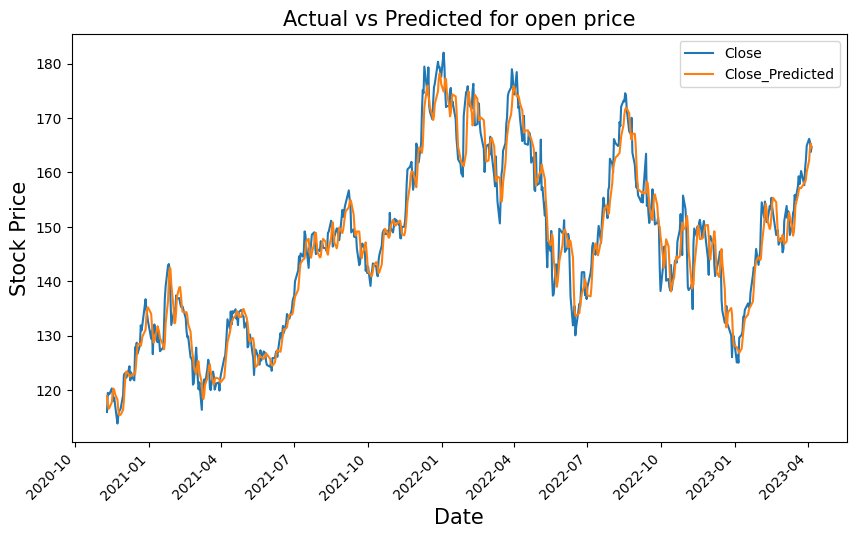

In [63]:
data_predicted[['Close', 'Close_Predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

In [64]:
data.shape

(3274, 1)

## Forecasting

In [65]:
fore_data = pd.read_csv("2023_2024_preprocessed_data.csv", index_col=0)
fore_data.head()

,Date,Close
0,2023-04-10,162.029999
1,2023-04-11,160.800003
2,2023-04-12,160.100006
3,2023-04-13,165.559998
4,2023-04-14,165.210007


In [66]:
fore_data.set_index('Date', drop=True, inplace=True)

In [67]:
fore_data[fore_data.columns] = mms.transform(fore_data)

testing_seq,testing_labels = create_sequence(fore_data)

fore_data["Close"] = mms.inverse_transform(fore_data[["Close"]])

In [68]:
testing_prediction = model.predict(testing_seq)

9/9 [==============================] - 0s 4ms/step


In [69]:
testing_inverse_prediction = mms.inverse_transform(testing_prediction)
testing_inverse_prediction.shape

(261, 1)

In [70]:
fore_data.iloc[50:].shape

(261, 1)

In [71]:

fore_data_predicted = pd.concat([fore_data.iloc[50:].copy(),
                  pd.DataFrame(testing_inverse_prediction,
                               columns=["Close_Predicted"],
                               index=fore_data[50:].index)],
                 axis=1)
fore_data_predicted.shape

(261, 2)

In [72]:
fore_data_predicted.head(60)

,Close,Close_Predicted
Date,,
2023-06-21,183.960007,181.805374
2023-06-22,187.000000,181.500336
2023-06-23,186.679993,182.410690
2023-06-26,185.270004,183.786682
2023-06-27,188.059998,184.412521
2023-06-28,189.250000,184.931335
2023-06-29,189.589996,185.547440
2023-06-30,193.970001,186.139526
2023-07-03,192.460007,187.776016


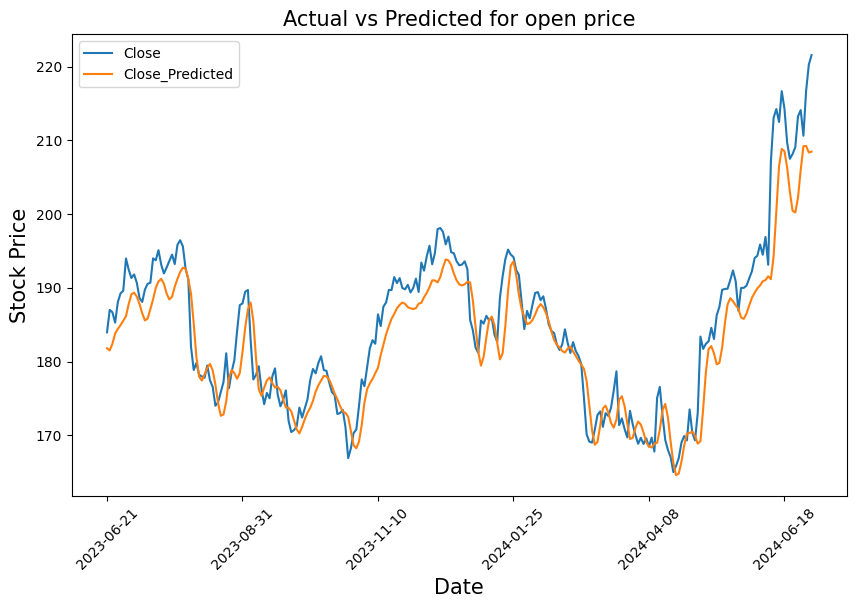

In [73]:
fore_data_predicted[['Close', 'Close_Predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()